# Philly Bail Fund
## Analysis of factors related to Bail Amounts

For more details, see the github repo: https://github.com/CodeForPhilly/pbf-analysis

[insert overview of approach here.. img?]

### Library Imports

In [63]:
### Standard Imports - Sorry PEP8 fans, do not look below
import pandas as pd, numpy as np, os, re, json, pickle, math, calendar
from time import time
from pprint import pprint
from pathlib import Path
from datetime import datetime

## Specific Imports
import hashlib

# frameworks
from sklearn.model_selection import GroupKFold, KFold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline

# feat engineering
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# modeling
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDRegressor
from sklearn.decomposition import TruncatedSVD

# validation and scoring
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, cross_validate


### Display options for notebooks
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 25)

### set path directories
curr_dir = Path(os.getcwd())
#print('Current Directory is: ', str(curr_dir))
data_dir = Path(curr_dir.parents[0] / 'Data/')
artifacts_dir = Path(curr_dir / 'artifacts/')

In [2]:
### Common project specific variables
FILENAME = '0c_distinct_dockets.csv'  # original data
TARGET_VARIABLE_NAME = 'bail_amount'
HOLDOUT_INDICATOR_NAME = 'holdout_ind'
HOLDOUT_SIZE = 0.80

### Helper Functions

In [3]:
# helper function to reduce memory footprint of the dataframe
def reduce_mem_usage(df, verbose=True):
    import numpy as np
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} MB ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

### Data Import

Also, check a hash to see if this file has changed since this code was written. If it changes, someone should review this notebook to make sure that the code still works.

In [4]:
# experimental - looking to find a way to prevent this notebook from continuing
# if by chance the dataset has changed
BLOCKSIZE = 65536
hasher = hashlib.md5()
with open(Path(data_dir) / FILENAME, 'rb') as afile:
    buf = afile.read(BLOCKSIZE)
    while len(buf) > 0:
        hasher.update(buf)
        buf = afile.read(BLOCKSIZE)
        
filehash = hasher.hexdigest()

with open(Path(artifacts_dir) / 'data_file_hash.txt', 'rb') as f:
    checkhash = pickle.load(f)
    
if filehash != checkhash:
    print("!! Warning !! The file is different than when this code was last updated. \nProceed with caution.")

In [5]:
# a bootleg way to update the hash manually, if we know everything is good to go
UPDATE_HASH_FLAG = False

if UPDATE_HASH_FLAG==True:
    with open(Path(artifacts_dir) / 'data_file_hash.txt', 'wb') as f:
        pickle.dump(filehash, f)

In [6]:
# read in the data and take a peek at it
indata = pd.read_csv(Path(data_dir) / FILENAME, parse_dates=['filing_date'], index_col='id')

indata.head(3)

,age,address,docket_number,filing_date,charge,represented_by,bail_type,bail_status,bail_amount,outstanding_bail_amount
id,,,,,,,,,,
3909,27.0,"Philadelphia, PA 19141",MC-51-CR-0011746-2020,2020-06-16 00:37:00+00:00,DUI: Gen Imp/Inc of Driving Safely - 1st Off,Defender Association of Philadelphia,Posted,ROR,0,0
4538,44.0,"Philadelphia, PA 19124",MC-51-CR-0011747-2020,2020-06-16 00:41:00+00:00,Verify Address or Photographed as Required,Defender Association of Philadelphia,Set,Monetary,50000,0
120,24.0,"Philadelphia, PA 19142",MC-51-CR-0011743-2020,2020-06-16 00:52:00+00:00,Criminal Mischief,Defender Association of Philadelphia,Posted,ROR,0,0


### Data Setup

A1. Keep = bail_amount, charge, bail_status, filing_date, age, represented_by

A2. Create hour of day and day of week from filing_date, then drop originial filing_date

A3. Delete rows where bail_status = 'Denied' (we will only worry about ones where there is a set amount)

##### A1: Keep only columns that might impact the bail amount


In [7]:
# drop things we know aren't useful
drop_list = ['address','docket_number','bail_type','outstanding_bail_amount']

indata.drop(columns=drop_list, inplace=True, errors='ignore')

##### A2: Parse Hour of Day and Day of Week, before dropping the date field

In [8]:
datecol = 'filing_date'

# hour of day
indata['filed_hour_of_day'] = indata[datecol].dt.hour

# day of the week with Monday=0, Sunday=6
indata['filed_day_of_week'] = indata[datecol].dt.dayofweek.apply(lambda x: calendar.day_abbr[x])

indata.drop(columns=[datecol], inplace=True, errors='ignore')

indata['charge'] = indata['charge'].str.lower().str.replace('[^\w\s]','')

##### A3: Remove rows where bail does not apply

In [9]:
# remove rows where bail amount is more than zero
clean = indata[indata['bail_amount']>0]

clean.head(5)

,age,charge,represented_by,bail_status,bail_amount,filed_hour_of_day,filed_day_of_week
id,,,,,,,
4538,44.0,verify address or photographed as required,Defender Association of Philadelphia,Monetary,50000,0,Tue
291,32.0,contempt for violation of order or agreement,Defender Association of Philadelphia,Monetary,50000,1,Tue
291,32.0,burglary overnight accommodations person pres...,Defender Association of Philadelphia,Monetary,75000,1,Tue
291,32.0,burglary overnight accommodations person pres...,Defender Association of Philadelphia,Monetary,75000,1,Tue
2396,51.0,simple assault,Defender Association of Philadelphia,Unsecured,25000,1,Tue


### Split data into Train and holdout

In case we want to do special encoding that uses target signals, we want to ensure we do this now. But, it means we'll have to remember to apply the transformations to the test dataset as well (more coding, blah)

So that I can compare this method with other software and techniques, I'm adding an indicator for the holdout and each of the 5 training folds, so that we can replicate results and compare directly.


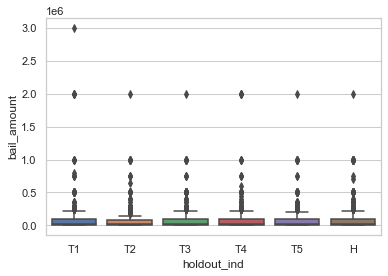

In [10]:
# a handy little routine that will add a partition indicator including holdout and folds
# this is handy for benchmarking in another tool where you want the exact same fold partitions
# and cant trust the random seed

with pd.option_context('mode.chained_assignment', None):
    temptrain, holdoutdata = train_test_split(
        clean,
        test_size=(1 - HOLDOUT_SIZE),
        random_state=321
    )

    kf = KFold(n_splits=5)
    i = 0
    for _ , test_index in kf.split(temptrain,temptrain[TARGET_VARIABLE_NAME]):
        i+=1
        temp = temptrain.iloc[test_index]
        temp[HOLDOUT_INDICATOR_NAME]='T' + str(i)

        if i==1:
            traindata = temp.copy()
        else:
            traindata = traindata.append(temp)

    holdoutdata[HOLDOUT_INDICATOR_NAME]='H'
    clean = pd.concat([traindata,holdoutdata])

# peek at the data
clean.head(3)

import seaborn as sns
sns.set(style="whitegrid")
ax = sns.boxplot(x=HOLDOUT_INDICATOR_NAME, y="bail_amount", data=clean)

In [11]:
# export this data so we can benchmark w/ AutoML tools if we want to
clean.to_csv(Path(artifacts_dir) / 'ready_for_external_tests.csv')

### Pipeline including Feature Engineering
B1. Encode categorical variables (bail_status, hour of day, day of week, represented_by, even charge!) 
using categorical_encoders library. Choose any method but best is probably Ordinal. Also 
good to try is just using alphabetical ordering and numbering them 1,2,3.. etc

B2. Impute numeric variable (age) with -9999

B3. Vectorize and process `charges` as text with NLP techniques

In [42]:
# split holdout and training data
train = clean[clean['holdout_ind'] != 'H']
holdout = clean[clean['holdout_ind'] == 'H']

# variables that need encoded or treated in special ways
vars_numeric = ['age']
vars_ordinal = ['represented_by','bail_status','filed_hour_of_day','filed_day_of_week']
#vars_tar = ['bail_status']
vars_txt = 'charge'

### Model only on text features

We'll first build a model using the text features, before feeding that prediction into a final model where the txt is now represented as a single column (probability)


##### (Text-Only Model) Grid Search for best parameters

In [43]:
#### text preprocessor
# note the .fit() is required for text processing
vocab = ['1st','1st off','agreement','arrest prior','assault','assault by','attempt','attempt burglary','attempt murder','attempt rape','attempt theft','by vehicle','child','compulsion','contempt','contempt for',
'crime','crime int','criminal','criminal attempt','criminal mischief','degree','delivery or','driving','driving safely','dui','dui gen','enforcement','enforcement officer','escape','firearm','firearm prohibited',
'first','first degree','for','for violation','forcible','forcible compulsion','from','from motor','gen','gen imp','imp','imp inc','inc','inc of','inflict serious','inj','instrument','instrument of','int',
'involuntary','involuntary manslaughter','law','law enforcement','manslaughter','mischief','motor vehicle','murder','murder of','of','of crime','of driving','of firearm','of law','of order','of the','off',
'officer','officer of','order','order or','other','per','person','person present','poss','poss instrument','possession','possession of','prior','prior to','prohibited','rape','rape forcible','requisition',
'safely','simple','simple assault','the','the first','theft','theft from','to requisition','tres','vehicle while','violation','while','while dui']

pipeline_txt = Pipeline(steps=[('vect_counts', CountVectorizer(vocabulary=vocab, lowercase=True, ngram_range=(1,3), analyzer='word'))
                               ,('vect_tfidf', TfidfTransformer())
                              ])

preprocessor = ColumnTransformer(
    transformers=[('txt', pipeline_txt.fit(train[vars_txt]), vars_txt)
                 ])

# initiate a model
submodel = SGDRegressor()

# dimensionality reduction
svd = TruncatedSVD()

# option A: One combined pipeline                  
#textpipe = Pipeline(steps=[('preprocessor', preprocessor),('svd', svd), ('submodel', submodel)])

# option B: Do it without svd (by using vocab instead)
textpipe_nosvd = Pipeline(steps=[('preprocessor', preprocessor), ('submodel', submodel)])

# grid search settings
params = {
    'submodel__tol': (0.0001, 0.0005, 0.001),
    'submodel__alpha': (0.0001, 0.0005, 0.001),
    'submodel__penalty': ('l2', 'elasticnet'),
    'submodel__max_iter': (1000, 5000)
}

# initialize a cross fold validation strategy
cv = GroupKFold(n_splits=5)

# multiprocessing requires the fork to happen in a __main__ protected block
if __name__ == "__main__":
    
    # initialize a grid search of the pipeline and parameters 
    gs = GridSearchCV(textpipe_nosvd, param_grid=params, cv = cv, refit=True, scoring='neg_root_mean_squared_error', n_jobs=-1)
    
    t0 = time()
    
    # grid search (go get coffee)
    print("Performing grid search...")
    xvars = list([vars_txt] + [HOLDOUT_INDICATOR_NAME])
    gs.fit(train[xvars], train[TARGET_VARIABLE_NAME], groups=train[HOLDOUT_INDICATOR_NAME])
    
    print("done in %0.3fs" % (time() - t0))
    print()
    print("Best score: %0.3f" % gs.best_score_)
    print("Best parameters set:")
    
    # print the best settings
    best_parameters = gs.best_estimator_.get_params()
    
    for param_name in sorted(params.keys()):
        pprint("\n%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
done in 19.201s

Best score: -155431.076
Best parameters set:
'\nsubmodel__alpha: 0.0001'
'\nsubmodel__max_iter: 5000'
"\nsubmodel__penalty: 'l2'"
'\nsubmodel__tol: 0.001'


##### Chosen Text Model

In [44]:
# text vectorizer
pipeline_txt = Pipeline(steps=[('vect_counts', CountVectorizer(vocabulary=vocab, lowercase=True, ngram_range=(1,3), analyzer='word'))
                              ,('vect_tfidf', TfidfTransformer())
                              ])

# text preprocessor
text_preprocessor = ColumnTransformer(
    transformers=[('txt', pipeline_txt.fit(train[vars_txt]), vars_txt)])

# text dimensionality reduction
#text_svd = TruncatedSVD(n_components=100, n_iter=5)

# Final submodel for text features
text_submodel = SGDRegressor(max_iter=10000, alpha=0.0, penalty='l2',tol=0.0005)

# hardcode the final pipeline
text_finalpipe = Pipeline(steps=[('text_preprocessor', text_preprocessor), ('text_submodel',text_submodel)])

text_model = text_finalpipe.fit(train[[vars_txt]], train[TARGET_VARIABLE_NAME])

# save it for later
with open(Path(artifacts_dir) / 'text_submodel.mdl', 'wb') as f:
    pickle.dump(text_model, f)

In [64]:
# save it for later
with open(Path(artifacts_dir) / 'text_submodel.mdl', 'wb') as f:
    pickle.dump(text_model, f)

##### Intermediate Scoring to replace 'charge' with numeric representation

I should be able to figure out how to include this in the pipeline later?

In [45]:
# this entire block could be written better

train['temp'] = text_model.predict(train[[vars_txt]])
holdout['temp'] = text_model.predict(holdout[[vars_txt]])

train = train.drop([vars_txt], axis=1)
holdout = holdout.drop([vars_txt], axis=1)

train = train.rename(columns={'temp': 'charge'})
holdout = holdout.rename(columns={'temp': 'charge'})

/Users/josh.berry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/josh.berry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


##### (Main Model) Grid Search for best parameters

In [51]:
#### Basic Pipelines
# impute missing for numeric columns
pipeline_numeric = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value=-9999))])

# ordinal encoding
pipeline_ordinal = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                          ('ord_encoding', ce.ordinal.OrdinalEncoder())])
# target encoding
#pipeline_tar = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),('tar_encoding', ce.SumEncoder())])

# TODO: fit text into a submodel as part of pipeline

#### one unified preprocessor
# note the .fit() is required for text processing
preprocessor = ColumnTransformer(
    transformers=[('num', pipeline_numeric, vars_numeric),
                  ('cat1', pipeline_ordinal, vars_ordinal)
                  #('cat2', pipeline_tar, vars_tar)
                 ], remainder='passthrough')

# initiate a model
rfr = RandomForestRegressor()

# name the final pipeline connected to the model                    
pipe = Pipeline(steps=[('preprocessor', preprocessor), ('regression', rfr)])

# parameter options for grid search
params = {"regression__max_depth": [6, None],
              "regression__max_features": [0.6, 0.8],
              "regression__min_samples_split": [10, 20],
              "regression__min_samples_leaf": [2, 5],
              "regression__n_estimators": [200,500]}

# initialize a cross fold validation strategy
cv = GroupKFold(n_splits=5)

# multiprocessing requires the fork to happen in a __main__ protected block
if __name__ == "__main__":
    
    # initialize a grid search of the pipeline and parameters 
    gs = GridSearchCV(pipe, param_grid=params, cv = cv, refit=True, scoring='neg_root_mean_squared_error', n_jobs=-1)

    t0 = time()
    
    # grid search (go get coffee)
    print('Performing grid search...')
    
    X = train.drop([TARGET_VARIABLE_NAME, HOLDOUT_INDICATOR_NAME], axis=1)
    y = train[TARGET_VARIABLE_NAME]
    
    gs.fit(X, y, groups=train[HOLDOUT_INDICATOR_NAME])
    
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % gs.best_score_)
    print("Best parameters set:")
    
    # print the best settings
    best_parameters = gs.best_estimator_.get_params()
    
    for param_name in sorted(params.keys()):
        pprint("\n%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
done in 32.185s

Best score: -141105.253
Best parameters set:
'\nregression__max_depth: None'
'\nregression__max_features: 0.6'
'\nregression__min_samples_leaf: 5'
'\nregression__min_samples_split: 10'
'\nregression__n_estimators: 500'


##### D1: Find the best Random Forest model

##### Test Performance of Model

In [58]:
# hardcode the model to the best settings
best_model_settings = RandomForestRegressor(n_estimators=500
                                            ,criterion='mse'
                                            ,max_depth=6
                                            ,min_samples_split=10
                                            ,min_samples_leaf=2
                                            ,min_weight_fraction_leaf=0.0
                                            ,max_features=0.6
                                            ,max_leaf_nodes=1000
                                            ,min_impurity_decrease=0.0
                                            ,bootstrap=False
                                            ,oob_score=False
                                            ,n_jobs=None
                                            ,random_state=1234
                                            ,verbose=0
                                            ,warm_start=False
                                            ,ccp_alpha=0.0
                                            ,max_samples=None)

preprocessor = ColumnTransformer(
    transformers=[('num', pipeline_numeric, vars_numeric),
                  ('cat1', pipeline_ordinal, vars_ordinal)
                 ], remainder='passthrough')

# hardcode the final pipeline
final_pipe = Pipeline(steps=[('preprocessor', preprocessor),('final_model', best_model_settings)])

# fixing a weird ordering problem
#train_new = pd.DataFrame(train, columns=train.columns)

# fit the model on the training data (remember this is in-sample and scores will look overfit)
model = final_pipe.fit(train_new.drop([TARGET_VARIABLE_NAME, HOLDOUT_INDICATOR_NAME], axis=1), y)

# predictions
train_y_pred = model.predict(train.drop([TARGET_VARIABLE_NAME, HOLDOUT_INDICATOR_NAME], axis=1))
holdout_y_pred = model.predict(holdout.drop([TARGET_VARIABLE_NAME, HOLDOUT_INDICATOR_NAME], axis=1))

# naive guess whatever the average of the training data was
naive_guess = pd.Series(np.mean(((train[TARGET_VARIABLE_NAME]) * len(train)) + (np.mean(holdout[TARGET_VARIABLE_NAME]) * len(holdout))) / (len(train) + len(holdout)))
naive_y_pred = naive_guess.repeat(len(holdout_y_pred))

In [65]:
# save it for later
with open(Path(artifacts_dir) / 'model.mdl', 'wb') as f:
    pickle.dump(model, f)

In [59]:
# calc the RMSE
train_mse = mean_squared_error(train[TARGET_VARIABLE_NAME], train_y_pred)
holdout_mse = mean_squared_error(holdout[TARGET_VARIABLE_NAME], holdout_y_pred)
naive_mse = mean_squared_error(holdout[TARGET_VARIABLE_NAME], naive_y_pred)

print('***** Error listed as RMSE ******')
print('Train (In-Sample): ' + str(round(math.sqrt(train_mse))))
print('CV: ' + str(-round(gs.best_score_)))
print('Holdout: ' + str(round(math.sqrt(holdout_mse))))
print('Naive: ' + str(round(math.sqrt(naive_mse))))

***** Error listed as RMSE ******
Train (In-Sample): 126277
CV: 141105.0
Holdout: 143622
Naive: 177913


Right now we have small data, but at least we have somewhat of a model that is slightly better than average.

### Analysis

E1. Matrix of correlation (mutual information?) to prove these are independent variables

E2. Permutation Importance to show the relative importance of each variable in the model (this is a better interpretation than the tree-importance that comes from the model itself)

E3. Partial Dependence Plots for each of the variables (except the text)

E4. Score original training dataset with model. Filter for observations where predicted value is either top 10% or bottom 10%. Run SHAP to extract #1 reason for each observation in the top/bottom 10%.

E5. Look for any cases where age, represented_by is the #1 factor for the bail_amount. These could be interesting cases to highlight

E6. Word cloud of the terms - this could take some work I'm not too familiar w/ this


##### E1: Correlation Matrix 
Can we use Mutual Information ?

In [ ]:
# I did check this in external tools and prove that they are independent - I just need to find time to code this in python and make a nice graphic

##### E2: Feature Impact

In [61]:
import eli5
from eli5.sklearn import PermutationImportance

x = train.drop([TARGET_VARIABLE_NAME, HOLDOUT_INDICATOR_NAME], axis=1)
y = train[TARGET_VARIABLE_NAME]

estimator = final_pipe.named_steps['final_model']
imputer = final_pipe.named_steps['preprocessor']

x2 = imputer.transform(x)

perm = PermutationImportance(estimator, random_state=1, cv=None)

perm.fit(x2, y)

features = list(x.columns)

eli5.explain_weights_df(perm, feature_names = features)

,feature,weight,std
0,charge,0.630151,0.032533
1,filed_hour_of_day,0.202640,0.039140
2,age,0.081307,0.004273
3,bail_status,0.068642,0.024312
4,represented_by,0.064173,0.008351
5,filed_day_of_week,0.031641,0.003237


In [ ]:
# need to make a better chart here where we normalize max weight = 1

##### E3: Feature Effects

##### E4. Feature Explanations

##### E5. Specific Examples

##### E6. Term Frequncy/ Word Cloud?